In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import warnings
from decimal import Decimal

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [3]:
def load_dataset():
    train_dataset = h5py.File('cats/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('cats/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [4]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y, classes = load_dataset()

In [5]:
train_set_y_orig.shape

(1, 209)

y = [0], it's a 'non-cat' picture.


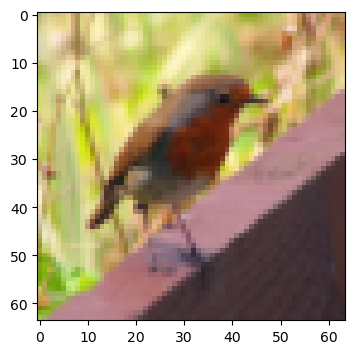

In [6]:
# Example of a picture
index = 10
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y_orig[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y_orig[:, index])].decode("utf-8") +  "' picture.")

In [7]:
X_train = train_set_x_orig.copy().reshape(train_set_x_orig.shape[0], -1).T/255
Y_train = train_set_y_orig.copy()
X_test = test_set_x_orig.copy().reshape(test_set_x_orig.shape[0], -1).T/255
Y_test = test_set_y.copy()

In [8]:
def sigmoid(Z):
    s = 1/(1 + np.exp(-Z))
    s = np.minimum(s, 0.99999) 
    s = np.maximum(s, 0.00001)
    return s

In [9]:
def relu(Z):
    A = np.maximum(0,Z)
    return A

In [10]:
class Layer:
    def __init__(self, node_num, activation = None) -> None:
        self.node_num = node_num
        self.activation = activation
    def __str__(self) -> str:
        return "node num:" + str(self.node_num)

In [11]:
def initialize_parameters(layers_dimensions):
    parameters = {}
    for i in range(1, len(layers_dimensions)):
        parameters["W" + str(i)] = np.random.randn(layers_dimensions[i].node_num, layers_dimensions[i - 1].node_num) * np.sqrt(2/layers_dimensions[i-1].node_num) 
        parameters["b" + str(i)] = np.zeros((layers_dimensions[i].node_num, 1)) 
    return parameters

In [12]:
def cost_function(Y, A, layers_dimensions, params, lambd = None):
    m = Y.shape[1]
    cost = (1./m) * (-np.dot(Y,np.log(A).T) - np.dot(1-Y, np.log(1-A).T))
    if lambd is not None:
        weight_sum = 0
        for i in range(1, len(layers_dimensions)):
            W = params["W" + str(i)]
            weight_sum += np.sum(np.square(W))
        cost = cost + 2 * lambd/m * weight_sum
    return cost

In [39]:
def forward_propagation(X, params, layers_dimensions, keep_prob = 1.0):
    A_prev = X
    dim_len = len(layers_dimensions)
    caches = []
    for i in range(1, dim_len):
        W = params["W" + (str(i))]
        b = params["b" + (str(i))]
        #print("W shape:" + str(W.shape))
        #print("A_prev shape:" + str(A_prev.shape))
        Z = np.dot(W, A_prev) + b
        activation = layers_dimensions[i].activation
        if activation == "relu":
            A = relu(Z)
            dropout_matrix = np.random.rand(A.shape[0], A.shape[1])
            dropout_matrix = (dropout_matrix < keep_prob).astype(int)
            A = np.multiply(A, dropout_matrix) 
            A = A / keep_prob
            D = dropout_matrix
            caches.append((A_prev, W, b, Z, D))
        elif activation == "sigmoid":
            A = sigmoid(Z)
            caches.append((A_prev, W, b, Z, None))
        A_prev = A.copy()
    return A_prev, caches

In [14]:
def linear_backward(A_prev, W, dZ, m, lambd): 
    dW = 1/m * np.dot(dZ,  A_prev.T)
        
    if lambd is not None:
        dW = dW + lambd/m * W
    db = 1/m * np.sum(dZ, axis = 1, keepdims = True)
    dA = np.dot(W.T, dZ)
       
    return (dA, dW, db)

In [15]:
def back_propagation(Y, AL, caches, layers_dimensions, lambd = None, keep_prob = 1.0):
    gradients = {}
    m = Y.shape[1]
    l = len(layers_dimensions)
    
    dA = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    for i in reversed(range(1, len(layers_dimensions))):
        (A_prev, W, b, Z, D) = caches[i - 1]
        
        if i < len(layers_dimensions) - 1:
            dA = np.multiply(dA, D) / keep_prob
        
        if layers_dimensions[i].activation == "sigmoid":
            dZ = dA * sigmoid_derivative(Z)
            (dA, dW, db) = linear_backward(A_prev, W, dZ, m, lambd)
            gradients["dW" + str(i)] = dW
            gradients["db" + str(i)] = db
        elif layers_dimensions[i].activation == "relu":
            dZ = dA * relu_derivative(Z)
            (dA, dW, db) = linear_backward(A_prev, W, dZ, m, lambd) 
            gradients["dW" + str(i)] = dW
            gradients["db" + str(i)] = db
    
    return gradients

In [16]:
def sigmoid_derivative(Z):
    s = 1/(1 + np.exp(-Z))
    s = np.minimum(s, 0.99999) 
    s = np.maximum(s, 0.00001)
    return s * (1 - s)

In [17]:
def relu_derivative(Z):
    s = Z >= 0
    return s.astype(int)

In [18]:
def update_params(params, gradients, layers_dimensions, learning_rate):
    updated_params = params.copy()
    for i in range(1, len(layers_dimensions)):
        updated_params["W" + str(i)] = updated_params["W" + str(i)] - learning_rate * gradients["dW" + str(i)]
        updated_params["b" + str(i)] = updated_params["b" + str(i)] - learning_rate * gradients["db" + str(i)]
    return updated_params

In [19]:
layers_dimensions = [Layer(X_train.shape[0]), Layer(20, "relu"), Layer(7, "relu"), Layer(5, "relu"), Layer(1, "sigmoid" )]

In [55]:
X_train[:,1].shape

(12288,)

In [53]:
np.expand_dims(X_train[:,1], axis = 1).shape

(12288, 1)

In [60]:
def build_model_sgd(X, Y, layers_dimensions):
    np.random.seed(3)
    keep_prob = 0.9
    lambd = None
    learning_rate = 0.01
    iterations = 100
    layers = layers_dimensions.copy()
    #layers[:0] = [Layer(X.shape[0])]
    params = initialize_parameters(layers)
    for i in range(0, iterations):
        cost_sum = 0
        for j in range(X.shape[1]):
            X_j = np.expand_dims(X[:, j], axis = 1)
            Y_j = np.expand_dims(Y[:, j], axis = 1)
            AL, caches = forward_propagation(X_j, params, layers, keep_prob)
            gradients = back_propagation(Y_j, AL, caches, layers, lambd = lambd, keep_prob = keep_prob)
            params = update_params(params, gradients, layers, learning_rate)
            cost_sum += cost_function(Y_j, AL, layers, params, lambd = lambd)
        cost = cost_sum/X.shape[1]
        if i % 10 == 0:
            print(i, cost)
    return params

In [20]:
def build_model(X, Y, layers_dimensions):
    np.random.seed(3)
    keep_prob = 0.9
    lambd = None
    learning_rate = 0.01
    iterations = 2500
    layers = layers_dimensions.copy()
    #layers[:0] = [Layer(X.shape[0])]
    params = initialize_parameters(layers)
    for i in range(0, iterations):
        AL, caches = forward_propagation(X, params, layers, keep_prob)
        gradients = back_propagation(Y, AL, caches, layers, lambd = lambd, keep_prob = keep_prob)
        
        params = update_params(params, gradients, layers, learning_rate)
        cost = cost_function(Y, AL, layers, params, lambd = lambd)
        if i % 100 == 0:
            print(i, cost)
    return params

In [61]:
params = build_model_sgd(X_train, Y_train, layers_dimensions)

0 [[0.67892966]]
10 [[0.64615451]]
20 [[0.61808431]]
30 [[0.63574534]]
40 [[0.6449822]]
50 [[0.63510535]]
60 [[0.61668813]]
70 [[0.62444697]]
80 [[0.63990703]]
90 [[0.60821949]]


In [62]:
def predict(X, params, layers_dimensions):
    layers = layers_dimensions.copy()
    A_prev = X
    for i in range(1, len(layers)):
        W = params["W" + str(i)]
        b = params["b" + str(i)]
        Z = np.dot(W, A_prev) + b
        if layers[i].activation == "relu":
            A = relu(Z)
        elif layers[i].activation == "sigmoid":
            A = sigmoid(Z)
        probs = A > 0.5
        A_prev = A
    return probs.astype(int)

In [63]:
def calculate_accuracy(Y, predictions):
    return np.sum((Y == predictions).astype(int))/Y.size

In [64]:
test_predictions = predict(X_test, params, layers_dimensions)

In [65]:
test_accuracy = calculate_accuracy(Y_test, test_predictions)
test_accuracy

0.36

In [66]:
train_predictions = predict(X_train, params, layers_dimensions)
train_accuracy = calculate_accuracy(Y_train, train_predictions)
print(train_accuracy)

0.6889952153110048


- Simple: 0.74 (learning rate = 0.01)
- Regularization norm2: 0.78 (lambd = 0.1)
- Dropout: 0.84

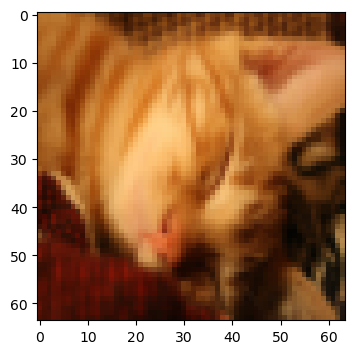

In [27]:
plt.imshow(test_set_x_orig[18])

In [28]:
for i in wrong_answers:
    plt.imshow(test_set_x[i])

NameError: name 'wrong_answers' is not defined